# Exercise 3: Reinforcement Learning

Extension of https://oist.github.io/BrainComputation/Reinforcement.html

In [1]:
import numpy as np
np.bool8 = np.bool_
import gym
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

### 1. SARSA Implementation

In [ ]:
# on-policy td control and learning; tabular Q(a,s)
def sarsa(self, max_steps=500, num_episodes=1000):
    self.Q = defaultdict(lambda: np.zeros(self.env.action_space.n))
    ep_hist = []
    for ep in range(num_episodes):
        state = self.env_reset()
        action, _ = self.act(state)
        netreward = 0.0
        done = False
        for t in range(max_steps):
            nstate, reward, done = self.env_step(action) # next state, reward
            naction, _ = self.act(nstate) # next action
            td_target = reward + self.gamma*self.Q[nstate][naction]*(not done)
            td_error = td_target - self.Q[state][action]
            self.Q[state][action] += self.alpha * td_error
            state = nstate
            action = naction
            netreward += reward
            if done:
                break
        ep_hist.append(netreward)
        if (ep+1)%50 == 0:
            avg_return = np.mean(ep_hist[-50:])
            print(f"Episode {ep+1}/{num_episodes} avg-last-50: {avg_return:.2f}")
    return ep_hist

### 2. Actor-Critic Implementation

In [ ]:
def actor_critic(self, max_steps=500, num_episodes=1000):
    self.V = defaultdict(float)
    self.Q = defaultdict(lambda: np.zeros(self.env.action_space.n))
    ep_hist = []
    for ep in range(num_episodes):
        state = self.env_reset()
        action, pi = self.act(state)
        netreward = 0.0
        done = False
        for t in range(max_steps):
            nstate, reward, done = self.env_step(action) # next state, reward
            # critic update
            td_error = reward + self.gamma * self.V[nstate]*(not done) - self.V[state]
            self.V[state] += self.alpha * td_error
            # actor update
            for a in range(self.env.action_space.n):
                if a == action:
                    self.Q[state][a] += self.alpha * td_error * (1 - pi[a]) # dp(a)/dQ(s,a)
                else:
                    self.Q[state][a] -= self.alpha * td_error * pi[a] # dp(b)/dQ(s,b)
            state = nstate
            action, pi = self.act(nstate) # next action
            netreward += reward
            if done:
                break
        ep_hist.append(netreward)
        if (ep+1)%50 == 0:
            avg_return = np.mean(ep_hist[-50:])
            print(f"Episode {ep+1}/{num_episodes} avg-last-50: {avg_return:.2f}")
    return ep_hist

### 3. RL Environment Testing

In [11]:
# cart-pole
gamma = 0.9 # discount factor
alpha = 0.1 # learning rate

class CartPoleEnv:
    """
    simple wrapper for gym cart-pole v1 environment with discretized 4D states and binary action
    Boltzmann (softmax) action selection with linear temperature decay
    """
    def __init__(self, alpha=alpha, gamma=gamma, num_bins=(6, 6, 18, 12), temp_start=2.0, temp_end=0.01,
                 temp_decay_steps=10000):
        self.alpha = alpha
        self.gamma = gamma
        self.num_bins = num_bins
        self.temp_start = temp_start
        self.temp_end = temp_end
        self.temp_decay_steps = temp_decay_steps
        self.steps_done = 0 # will increment whenever act(...) is called

        # cart position: [-2.4, 2.4]
        # cart velocity: [-3.0, 3.0]
        # pole angle: [-0.7854, 0.7854] radians (≈ ±45°)
        # pole angular velocity: [-4.0, 4.0]
        self.env = gym.make("CartPole-v1")
        self.bin_edges = [
            np.linspace(-2.4, 2.4, num_bins[0] - 1),
            np.linspace(-3.0, 3.0, num_bins[1] - 1),
            np.linspace(-0.7854, 0.7854, num_bins[2] - 1),
            np.linspace(-4.0, 4.0, num_bins[3] - 1),
        ]
        self.Q = defaultdict(lambda: np.zeros(self.env.action_space.n))
    
    def discretize(self, state):
        # discretizes continuous observation and returns state bin index
        discrete_indices = []
        for dim_idx, val in enumerate(state):
            # edges = self.bin_edges[dim_idx]
            i = np.digitize(val, self.bin_edges[dim_idx])
            discrete_indices.append(i)
        return tuple(discrete_indices)
    
    def get_temperature(self):
        # linear decay of temp over act() calls
        self.steps_done += 1
        frac = min(self.steps_done / self.temp_decay_steps, 1.0)
        return self.temp_start + frac * (self.temp_end - self.temp_start)
    
    def act(self, state):
        q_vals = self.Q[state]
        tau = self.get_temperature()
        max_q = np.max(q_vals)
        exp_prefs = np.exp((q_vals - max_q) / tau)
        probs = exp_prefs / np.sum(exp_prefs)
        return np.random.choice(self.env.action_space.n, p=probs), probs
    
    def env_reset(self):
        state, _ = self.env.reset()
        return self.discretize(state)
    
    def env_step(self, action):
        state, reward, terminated, truncated, _ = self.env.step(action) # gym v0.26+
        done = terminated or truncated
        return self.discretize(state), reward, done

In [4]:
# test sarsa
CartPoleEnv.sarsa = sarsa
env_wrapper = CartPoleEnv()
sarsa_learn_history = env_wrapper.sarsa()
env_wrapper.env.close()
test_env = gym.make("CartPole-v1", render_mode="rgb_array")
env_wrapper.env = test_env
test_returns = []
frames = []
for _ in range(10):
    s = env_wrapper.env_reset()
    done = False
    ep_ret = 0
    while not done:
        # purely greedy (τ = 0): pick action = argmax Q[s]
        a = int(np.argmax(env_wrapper.Q[s]))
        frame = env_wrapper.env.render()
        frames.append(frame)
        s, r, done = env_wrapper.env_step(a)
        ep_ret += r
    test_returns.append(ep_ret)
print("Average test return:", np.mean(test_returns))
env_wrapper.env.close()
fig = plt.figure(figsize=(6, 4))
plt.axis("off")
im = plt.imshow(frames[0])
def update(i):
    im.set_array(frames[i])
    return [im]
ani = FuncAnimation(fig, update, frames=len(frames), interval=50, blit=True, repeat=False)
plt.close(fig)
HTML(ani.to_html5_video())

Episode 50/1000 avg-last-50: 28.96
Episode 100/1000 avg-last-50: 21.28
Episode 150/1000 avg-last-50: 23.64
Episode 200/1000 avg-last-50: 24.00
Episode 250/1000 avg-last-50: 22.86
Episode 300/1000 avg-last-50: 28.56
Episode 350/1000 avg-last-50: 32.12
Episode 400/1000 avg-last-50: 73.48
Episode 450/1000 avg-last-50: 62.90
Episode 500/1000 avg-last-50: 72.10
Episode 550/1000 avg-last-50: 71.76
Episode 600/1000 avg-last-50: 87.04
Episode 650/1000 avg-last-50: 75.46
Episode 700/1000 avg-last-50: 83.62
Episode 750/1000 avg-last-50: 88.84
Episode 800/1000 avg-last-50: 82.58
Episode 850/1000 avg-last-50: 79.88
Episode 900/1000 avg-last-50: 81.32
Episode 950/1000 avg-last-50: 86.06
Episode 1000/1000 avg-last-50: 74.24
Average test return: 85.5


In [12]:
# test actor-critic
CartPoleEnv.actor_critic = actor_critic
env_wrapper = CartPoleEnv()
ac_learn_history = env_wrapper.actor_critic()
env_wrapper.env.close()
test_env = gym.make("CartPole-v1", render_mode="rgb_array")
env_wrapper.env = test_env
test_returns = []
frames = []
for _ in range(10):
    s = env_wrapper.env_reset()
    done = False
    ep_ret = 0
    while not done:
        # purely greedy (τ = 0): pick action = argmax Q[s]
        a = int(np.argmax(env_wrapper.Q[s]))
        frame = env_wrapper.env.render()
        frames.append(frame)
        s, r, done = env_wrapper.env_step(a)
        ep_ret += r
    test_returns.append(ep_ret)
print("Average test return:", np.mean(test_returns))
env_wrapper.env.close()
fig = plt.figure(figsize=(6, 4))
plt.axis("off")
im = plt.imshow(frames[0])
def update(i):
    im.set_array(frames[i])
    return [im]
ani = FuncAnimation(fig, update, frames=len(frames), interval=50, blit=True, repeat=False)
plt.close(fig)
HTML(ani.to_html5_video())

Episode 50/1000 avg-last-50: 27.32
Episode 100/1000 avg-last-50: 45.08
Episode 150/1000 avg-last-50: 95.24
Episode 200/1000 avg-last-50: 130.34
Episode 250/1000 avg-last-50: 142.24
Episode 300/1000 avg-last-50: 148.14
Episode 350/1000 avg-last-50: 139.14
Episode 400/1000 avg-last-50: 132.24
Episode 450/1000 avg-last-50: 142.64
Episode 500/1000 avg-last-50: 149.12
Episode 550/1000 avg-last-50: 131.36
Episode 600/1000 avg-last-50: 142.78
Episode 650/1000 avg-last-50: 135.32
Episode 700/1000 avg-last-50: 140.86
Episode 750/1000 avg-last-50: 137.40
Episode 800/1000 avg-last-50: 136.62
Episode 850/1000 avg-last-50: 131.62
Episode 900/1000 avg-last-50: 143.26
Episode 950/1000 avg-last-50: 143.04
Episode 1000/1000 avg-last-50: 146.44
Average test return: 131.2


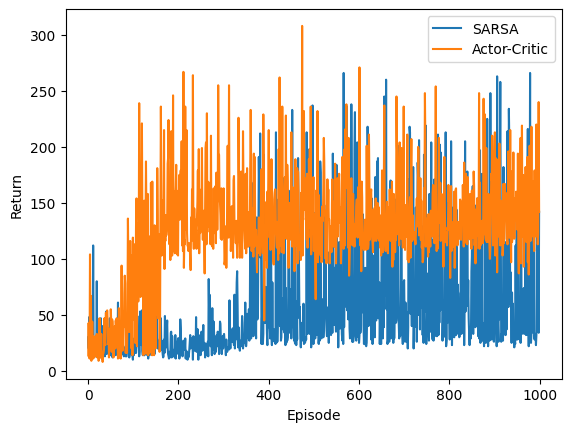

In [13]:
plt.plot(sarsa_learn_history, label="SARSA")
plt.plot(ac_learn_history,   label="Actor-Critic")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()